In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
con = sqlite3.connect('Campsite_data_4k.db')
query = ''' SELECT * FROM Venues'''
completed_venues = pd.read_sql_query(query,con).drop('index',axis=1)
query = ''' SELECT Campsite_Name, Latitude, Longitude FROM Sites WHERE Campsite_Name like '%RV%' AND Campsite_Name not like '%closed%'   '''
df_RV = pd.read_sql_query(query,con).drop_duplicates()
con.close()
Camp_sites_onehot = pd.get_dummies(completed_venues[['Venue_Category']], prefix="", prefix_sep="")
Camp_sites_onehot['Latitude'] = completed_venues['Latitude']
Camp_sites_onehot = Camp_sites_onehot[[Camp_sites_onehot.columns[-1]] + list(Camp_sites_onehot.columns[:-1])]
campsite_grouped = Camp_sites_onehot.groupby('Latitude').mean().reset_index()
campsite_grouped_clustering = campsite_grouped.drop('Latitude', 1)
campsite_grouped

,Latitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airfield,Airport,Airport Food Court,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,23.686356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,23.701440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,24.150010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0
3,24.568251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,24.582099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,64.832576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4854,64.835300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4855,64.839585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4856,64.962006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
model = AgglomerativeClustering(distance_threshold=4.2, n_clusters=None)

In [5]:
model = model.fit(campsite_grouped_clustering)

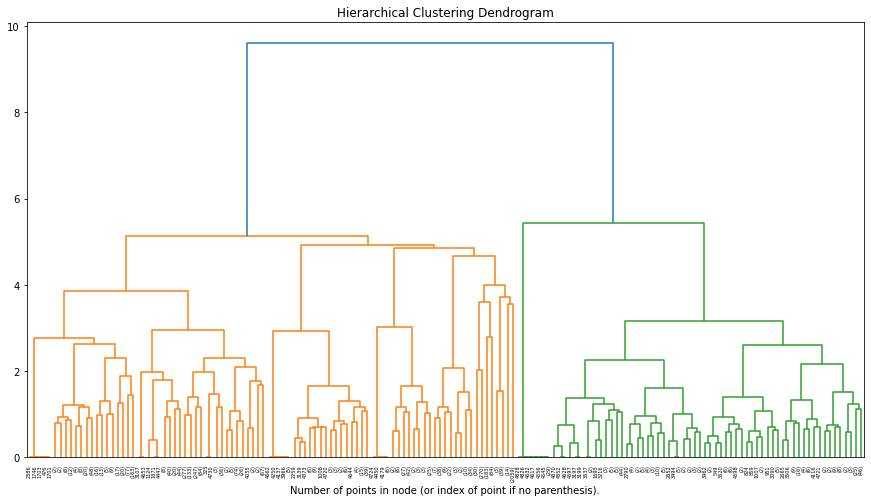

In [17]:
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('Dendogram.png',dpi=300)
plt.show()

In [7]:
model.labels_.max()

6

In [8]:
campsite_grouped.insert(0, 'Agg_Cluster_Labels', model.labels_)
df_RV = df_RV.reset_index().set_index('Latitude')
campsite_grouped = campsite_grouped.set_index('Latitude')

In [9]:
df_RV['Agg_Cluster_Labels'] = campsite_grouped['Agg_Cluster_Labels']
df_RV = df_RV.reset_index()
df_RV

,Latitude,index,Campsite_Name,Longitude,Agg_Cluster_Labels
0,44.030277,0,10 Acres Campground and RV Park,-73.403468,1.0
1,26.145834,1,1015 RV Park,-97.958195,1.0
2,51.415188,2,11 Bridges Campground and RV Park,-112.632344,3.0
3,58.716979,3,115 Creek Rest Area (no services),-124.912576,NaN
4,62.387044,4,1202 Motor Inn and RV Park,-140.873463,2.0
...,...,...,...,...,...
5306,37.236637,5306,Zion RV and Campground,-112.856060,NaN
5307,37.231969,5307,Zion West RV Park,-113.364556,NaN
5308,37.170192,5308,Zion's Gate RV Resort,-113.373832,NaN
5309,35.224768,5309,Zuni Village RV Park,-114.014515,NaN


In [10]:
campsite_grouped

,Agg_Cluster_Labels,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airfield,Airport,Airport Food Court,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Latitude,,,,,,,,,,,,,,,,,,,,,
23.686356,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
23.701440,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
24.150010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0
24.568251,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
24.582099,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64.832576,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
64.835300,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
64.839585,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [11]:
range_i = list(range(1,model.labels_.max()+2))
range_labels = []
for i in range_i:
    range_labels.append(str(i-1))
range_labels

['0', '1', '2', '3', '4', '5', '6']

In [12]:
range_i = list(range(1,model.labels_.max()+2))
df_clusters = []
df_clusters_stats = []
top_ten = []
for cluster in range_i:
    df_clusters.append(campsite_grouped[campsite_grouped['Agg_Cluster_Labels'] == cluster-1])
    cols = (df_clusters[-1] != 0).any()
    df_clusters[-1] = df_clusters[-1][cols[cols].index]
    try:
        df_clusters_stats.append(df_clusters[-1].drop(['Agg_Cluster_Labels'],1).describe().T.sort_values(by='mean', ascending=False))
    except:
        df_clusters_stats.append(df_clusters[-1].describe().T.sort_values(by='mean', ascending=False))
    temp = {}
    temp['name'] = 'Cluster {}'.format(cluster-1)
    lo = 0
    for top in df_clusters_stats[-1].iloc[:10].reset_index()['index'].tolist():
        lo = lo+1
        temp[str(lo)] = top
    top_ten.append(temp)
    print(cluster)
df_top_ten = pd.DataFrame(top_ten).set_index(['name'])
df_top_ten

1
2
3
4
5
6
7


,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,American Restaurant,Hotel,Mexican Restaurant,Coffee Shop,Park,Sandwich Place,Pizza Place,Bar,Campground,Convenience Store
Cluster 1,Fast Food Restaurant,Convenience Store,Discount Store,Gas Station,Pizza Place,Sandwich Place,Grocery Store,American Restaurant,Mexican Restaurant,Hotel
Cluster 2,RV Park,American Restaurant,Intersection,Campground,Park,Golf Course,Hotel,Lake,Harbor / Marina,Home Service
Cluster 3,Campground,Lake,Farm,Trail,Scenic Lookout,RV Park,Beach,Golf Course,Construction & Landscaping,Park
Cluster 4,Lake,Harbor / Marina,Campground,American Restaurant,Construction & Landscaping,Food,Home Service,Golf Course,Convenience Store,Bar
Cluster 5,Campground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cluster 6,Construction & Landscaping,Campground,American Restaurant,Gas Station,Golf Course,Farm,Post Office,Home Service,Business Service,Food


In [18]:
con = sqlite3.connect('Campsite_data_4k.db')
df_top_ten.reset_index().to_sql('Agg_top_ten',con,if_exists='replace')
con.close()

In [13]:
# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_RV.groupby('Agg_Cluster_Labels').count().reset_index()['Agg_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Latitude'], df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Longitude'], df_RV.reset_index()[df_RV['Agg_Cluster_Labels']==cluster]['Campsite_Name']):
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Agg/Cluster {} from analysis.html'.format(cluster))

In [14]:
df_RV.groupby('Agg_Cluster_Labels').count()

,Latitude,index,Campsite_Name,Longitude
Agg_Cluster_Labels,,,,
0.0,2684,2684,2684,2684
1.0,1510,1510,1510,1510
2.0,121,121,121,121
3.0,286,286,286,286
4.0,102,102,102,102
5.0,35,35,35,35
6.0,125,125,125,125


In [15]:
con = sqlite3.connect('Campsite_data_4k.db')
df_RV.to_sql('Agg',con,if_exists='replace')
campsite_grouped.reset_index().to_sql('Agg_grouped',con,if_exists='replace')
con.close()

/home/theia/.local/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,
